### **1.DATA SCIENCE SOLUTIONS**  


### <img src="data_science_solutions.jpg" alt="Data Science Solutions" width="200" title="Data Science Solutions">



###  2. PROJETO LEGAL ANALYTICS 

### Para iniciar esse projeto, o banco entrou no site do Tribunal de Justiça de São Paulo e extraiu aleatoriamente uma amostra de dados de 449 processos abertos e finalizados contra o banco sobre Taxas Abusivas (Data base: Segundo semestre de 2019). Com suporte nessa amostra, o objetivo da presente análise é desvelar os fatores associados ao ganho de causas.

### 3. IMPORTAÇÃO DOS PACOTES BÁSICOS DO PROJETO

In [102]:
# Pacotes basicos
import pandas as pd
import numpy as np
from scipy import stats

# Pacotes de modelagem
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import tree


# Pacotes de visualização de dados 
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Pacotes de metricas de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from sklearn.metrics import confusion_matrix

# Pacote de geracacao de documentação 
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

# Pacote de limpeza
import gc

### 4. IMPORTAÇÃO DA BASE DE DADOS

In [103]:
# importa base
df_original = pd.read_excel ("legal_analytics.xlsx")
df_original

,sentenca,data_julgamento,regiao_comarca,tipo_estrategia,taxa_contratada,valor_indenizacao
0,1,2019-07-01,Oeste,Estrategia C,3.1,NaN
1,1,2019-07-01,Norte,Estrategia C,2.5,NaN
2,0,2019-07-02,Sul,Estrategia A,4.0,2.247
3,1,2019-07-02,Sul,Estrategia B,2.6,NaN
4,1,2019-07-03,Oeste,Estrategia B,4.1,NaN
...,...,...,...,...,...,...
444,1,2019-12-29,Leste,Estrategia C,3.8,NaN
445,0,2019-12-30,Centro,Estrategia C,3.3,3.599
446,0,2019-12-30,Norte,Estrategia B,3.0,2.469
447,0,2019-12-31,Leste,Estrategia A,3.1,2.944


### 5. TRATAMENTO E LIMPEZA DE DADOS

### 5.1 Valores Ausentes (Missing Values)

In [104]:
df_original.isnull().sum()

sentenca               0
data_julgamento        0
regiao_comarca         0
tipo_estrategia        0
taxa_contratada        0
valor_indenizacao    199
dtype: int64

In [105]:
# Preenche NaN por zero
df_legal = df_original.fillna(0)

### 5.2 Duplicações

In [106]:
df_legal.duplicated().sum()

0

### 5.3 Tipos de variáveis 

In [107]:
df_legal.shape

(449, 6)

In [108]:
df_legal.head(3)

,sentenca,data_julgamento,regiao_comarca,tipo_estrategia,taxa_contratada,valor_indenizacao
0,1,2019-07-01,Oeste,Estrategia C,3.1,0
1,1,2019-07-01,Norte,Estrategia C,2.5,0
2,0,2019-07-02,Sul,Estrategia A,4.0,2.247


In [109]:
df_legal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sentenca           449 non-null    int64         
 1   data_julgamento    449 non-null    datetime64[ns]
 2   regiao_comarca     449 non-null    object        
 3   tipo_estrategia    449 non-null    object        
 4   taxa_contratada    449 non-null    float64       
 5   valor_indenizacao  449 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 21.2+ KB


### 5.4 Transformação do tipo de variável

In [110]:
# Transformacao da variavel com valores NaN
df_legal['valor_indenizacao'] = (
    df_legal['valor_indenizacao']
    .astype(str)                         # Garante que estamos lidando com strings.
    .str.replace(',', '.', regex=False)  # Substitui vírgulas por pontos.
    .str.strip()                         # Remove espaços em branco.
    .replace('', np.nan, regex=False)    # Substitui strings vazias por NaN.
    .astype(float)                       # Converte para float.
)


### 5.5 Confirmação da transformação do tipo de variável

In [111]:
df_legal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sentenca           449 non-null    int64         
 1   data_julgamento    449 non-null    datetime64[ns]
 2   regiao_comarca     449 non-null    object        
 3   tipo_estrategia    449 non-null    object        
 4   taxa_contratada    449 non-null    float64       
 5   valor_indenizacao  449 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 21.2+ KB


### 6. ANÁLISE EXPLORATÓRIA DE DADOS 

### 6.1 Cria função para Information Value (IV)

In [112]:
# Cria função Information Value (IV)
class analise_iv:
    
    def __init__(self, dataframe=df_legal, target='sentenca'):
        """
        Inicializa o objeto analise_iv com o DataFrame e a variável target especificada.
        
        Parâmetros:
            dataframe (pandas.DataFrame): O DataFrame que contém os dados para análise.
            target (str): O nome da coluna no DataFrame que será usada como variável target.
        """
        self.df = dataframe
        self.target = target
        self.df_tabs_iv = pd.DataFrame()
    
    def __str__(self):
        """
        Fornece uma representação textual do objeto, mostrando informações básicas.
        """
        return f'Analisador IV para DataFrame com {self.df.shape[0]} registros e {self.df.shape[1]} variáveis, utilizando "{self.target}" como variável target.'
        
    def valor_iv(self, feature):
        """
        Calcula o Information Value (IV) para uma determinada feature em relação à variável target.
        
        Parâmetros:
            feature (str): O nome da coluna no DataFrame para a qual o IV será calculado.
        
        Retorna:
            pandas.DataFrame: Um DataFrame contendo os cálculos do IV para a feature especificada.
        """
        # Cria a contagem de Target_1 e Target_0
        df_aux = self.df.copy()
        df2 = pd.crosstab(index=df_aux[feature], columns=df_aux[self.target], margins=False)
        df2.columns = df2.columns.astype(str)  # Garante que o nome das colunas seja string para evitar problemas

        # Assegura que ambas as colunas, '0' e '1', existam
        if '0' not in df2.columns:
            df2['0'] = 0
        if '1' not in df2.columns:
            df2['1'] = 0
        
        df2 = df2[['0', '1']]  # Reordena as colunas se necessário
        df2.columns = ['#Target_0', '#Target_1']
        df2 = df2.div(df2.sum(axis=1), axis=0) * 100  # Calcula a porcentagem
        
        # Cálculo de IV
        df2['Distr_T1'] = df2['#Target_1'] / df2['#Target_1'].sum()
        df2['Distr_T0'] = df2['#Target_0'] / df2['#Target_0'].sum()
        df2.replace({0: np.nan}, inplace=True)  # Substitui 0 por NaN para evitar divisão por zero no log
        df2['WOE'] = np.log(df2['Distr_T1'] / df2['Distr_T0'])
        df2['IV'] = (df2['Distr_T1'] - df2['Distr_T0']) * df2['WOE']
        df2.replace({np.nan: 0}, inplace=True)  # Substitui NaN de volta por 0
        
        # Preparação final do DataFrame
        df2 = df2.reset_index()
        df2['Variavel'] = feature
        df2 = df2[['Variavel', feature, '#Target_0', '#Target_1', 'Distr_T1', 'Distr_T0', 'WOE', 'IV']]
        
        # Armazena os resultados
        self.df_tabs_iv = pd.concat([self.df_tabs_iv, df2[['Variavel', 'IV']]], axis=0)
        
        return df2
    
    def get_bivariada(self, feature='all_vars'):
        """
        Executa a análise bivariada para uma ou todas as features do DataFrame.
        """
        if feature == 'all_vars':
            vars = [col for col in self.df.columns if col != self.target]
            for var in vars:
                self.valor_iv(var)
            print("Análise bivariada completa para todas as variáveis.")
        else:
            tabela = self.valor_iv(feature)
            display(tabela)
                    
    def get_lista_iv(self):
        """
        Agrupa e retorna a lista dos Information Values calculados para cada variável.
        """
        lista_iv = self.df_tabs_iv.groupby('Variavel')['IV'].sum().sort_values(ascending=False)
        return lista_iv





### 6.1.2 Aplica a função ao projeto df_legal

In [113]:
#Instancia a classe
analise_legal_iv = analise_iv(df_legal)

# Imprime a representação textual do objeto
print(analise_legal_iv)


Analisador IV para DataFrame com 449 registros e 6 variáveis, utilizando "sentenca" como variável target.


In [114]:
# Executa a análise bivariada na variável de interesse
analise_legal_iv.get_bivariada('taxa_contratada')

,Variavel,taxa_contratada,#Target_0,#Target_1,Distr_T1,Distr_T0,WOE,IV
0,taxa_contratada,0.3,0.000000,100.000000,0.055700,0.000000,0.000000,0.000000
1,taxa_contratada,0.9,0.000000,100.000000,0.055700,0.000000,0.000000,0.000000
2,taxa_contratada,1.0,100.000000,0.000000,0.000000,0.041586,0.000000,0.000000
3,taxa_contratada,1.3,25.000000,75.000000,0.041775,0.010396,1.390834,0.043642
4,taxa_contratada,1.4,33.333333,66.666667,0.037133,0.013862,0.985369,0.022931
5,taxa_contratada,1.5,16.666667,83.333333,0.046417,0.006931,1.901659,0.075088
6,taxa_contratada,1.6,33.333333,66.666667,0.037133,0.013862,0.985369,0.022931
7,taxa_contratada,1.7,0.000000,100.000000,0.055700,0.000000,0.000000,0.000000
8,taxa_contratada,1.8,42.857143,57.142857,0.031829,0.017822,0.579904,0.008122
9,taxa_contratada,1.9,33.333333,66.666667,0.037133,0.013862,0.985369,0.022931


In [115]:
# Executa a análise bivariada na variável 'regiao_comarca'
analise_legal_iv.get_bivariada('data_julgamento')

,Variavel,data_julgamento,#Target_0,#Target_1,Distr_T1,Distr_T0,WOE,IV
0,data_julgamento,2019-07-01,0.000000,100.000000,0.012990,0.000000,0.000000,0.000000
1,data_julgamento,2019-07-02,50.000000,50.000000,0.006495,0.005050,0.251699,0.000364
2,data_julgamento,2019-07-03,33.333333,66.666667,0.008660,0.003366,0.944846,0.005001
3,data_julgamento,2019-07-04,0.000000,100.000000,0.012990,0.000000,0.000000,0.000000
4,data_julgamento,2019-07-05,75.000000,25.000000,0.003247,0.007574,-0.846913,0.003665
...,...,...,...,...,...,...,...,...
171,data_julgamento,2019-12-27,100.000000,0.000000,0.000000,0.010099,0.000000,0.000000
172,data_julgamento,2019-12-28,100.000000,0.000000,0.000000,0.010099,0.000000,0.000000
173,data_julgamento,2019-12-29,0.000000,100.000000,0.012990,0.000000,0.000000,0.000000
174,data_julgamento,2019-12-30,100.000000,0.000000,0.000000,0.010099,0.000000,0.000000


In [116]:
# Executa a análise bivariada na variável 'regiao_comarca'
analise_legal_iv.get_bivariada('regiao_comarca')

,Variavel,regiao_comarca,#Target_0,#Target_1,Distr_T1,Distr_T0,WOE,IV
0,regiao_comarca,Centro,61.702128,38.297872,0.172698,0.221761,-0.250055,0.012268
1,regiao_comarca,Leste,52.808989,47.191011,0.212800,0.189798,0.114391,0.002631
2,regiao_comarca,Norte,58.426966,41.573034,0.187467,0.209989,-0.113457,0.002555
3,regiao_comarca,Oeste,54.761905,45.238095,0.203994,0.196817,0.035814,0.000257
4,regiao_comarca,Sul,50.537634,49.462366,0.223042,0.181635,0.205363,0.008504


In [117]:
# Para executar a análise bivariada para uma variável específica, como 'regiao_comarca'
analise_legal_iv.get_bivariada('tipo_estrategia')

,Variavel,tipo_estrategia,#Target_0,#Target_1,Distr_T1,Distr_T0,WOE,IV
0,tipo_estrategia,Estrategia A,60.256410,39.743590,0.296116,0.363464,-0.204927,0.013801
1,tipo_estrategia,Estrategia B,46.666667,53.333333,0.397369,0.281491,0.344764,0.039951
2,tipo_estrategia,Estrategia C,58.860759,41.139241,0.306515,0.355045,-0.146979,0.007133


In [118]:
analise_legal_iv.get_bivariada('valor_indenizacao')

,Variavel,valor_indenizacao,#Target_0,#Target_1,Distr_T1,Distr_T0,WOE,IV
0,valor_indenizacao,0.000,0.0,100.0,1.0,0.000000,0.0,0.0
1,valor_indenizacao,1.583,100.0,0.0,0.0,0.004405,0.0,0.0
2,valor_indenizacao,1.915,100.0,0.0,0.0,0.004405,0.0,0.0
3,valor_indenizacao,1.938,100.0,0.0,0.0,0.004405,0.0,0.0
4,valor_indenizacao,1.947,100.0,0.0,0.0,0.004405,0.0,0.0
...,...,...,...,...,...,...,...,...
223,valor_indenizacao,4.140,100.0,0.0,0.0,0.004405,0.0,0.0
224,valor_indenizacao,4.184,100.0,0.0,0.0,0.004405,0.0,0.0
225,valor_indenizacao,4.211,100.0,0.0,0.0,0.004405,0.0,0.0
226,valor_indenizacao,4.271,100.0,0.0,0.0,0.004405,0.0,0.0


In [119]:
# lista de IVs calculados
iv_lista = analise_legal_iv.get_lista_iv()
print(iv_lista)

Variavel
taxa_contratada      0.410750
data_julgamento      0.226953
tipo_estrategia      0.060885
regiao_comarca       0.026216
valor_indenizacao    0.000000
Name: IV, dtype: float64


### 6.1.3 Escala de Valores do Information Value (IV)

In [120]:
#Cria função de classificação IV das variáveis
def classificar_iv(df_iv):
    """
    Classifica os valores de IV de acordo com sua força preditiva.

    Parâmetros:
        df_iv (pandas.DataFrame): DataFrame contendo pelo menos duas colunas: 'Variavel' e 'IV',
                                  onde 'IV' é o valor de Information Value calculado para cada variável.
    """
    # Define as categorias de força preditiva
    categorias = [
        (0.0, 0.02, "Considerado inútil para previsão"),
        (0.02, 0.1, "Fraco preditor"),
        (0.1, 0.3, "Poder preditivo médio"),
        (0.3, 0.5, "Forte preditor"),
        (0.5, float('inf'), "Muito forte preditor"),
    ]
    
    # Itera sobre o DataFrame e classifica cada IV
    for index, row in df_iv.iterrows():
        variavel = row['Variavel']
        iv = row['IV']
        for min_val, max_val, descricao in categorias:
            if min_val <= iv <= max_val:  # Inclui o limite inferior na comparação
                print(f"{variavel}: IV de {iv:.5f} - {descricao}")
                break





In [121]:
    # Classifica as variáveis com poder preditivo do maior para o menor 
    df_legal_iv = pd.DataFrame({
    'Variavel': ['taxa_contratada', 'data_julgamento', 'tipo_estrategia', 'regiao_comarca', 'valor_indenizacao'],
    'IV': [0.410750, 0.226953, 0.060885, 0.026216, 0.000000]})
    
    classificar_iv(df_legal_iv)

taxa_contratada: IV de 0.41075 - Forte preditor
data_julgamento: IV de 0.22695 - Poder preditivo médio
tipo_estrategia: IV de 0.06089 - Fraco preditor
regiao_comarca: IV de 0.02622 - Fraco preditor
valor_indenizacao: IV de 0.00000 - Considerado inútil para previsão


### 6.2 Tabela de Frequência: Região da Comarca (variável categórica)

In [122]:
# Calcula a Frequência Absoluta para a coluna 'regiao_comarca'
freq_absoluta_comarca = df_legal['regiao_comarca'].value_counts().sort_index()

# Calcula a Frequência Relativa (em %) para a coluna 'regiao_comarca' abrangendo duas casas decimais
freq_relativa_comarca = (df_legal['regiao_comarca'].value_counts(normalize=True).sort_index() * 100).round(2)

# Calcula a Frequência Acumulada (em %) abrangendo duas casas decimais
freq_acumulada_comarca = freq_relativa_comarca.cumsum().round(2)

# Cria um DataFrame para reunir todas as frequências
tabela_frequencia_comarca = pd.DataFrame({
    'Frequência Absoluta': freq_absoluta_comarca,
    'Frequência Relativa (%)': freq_relativa_comarca,
    'Frequência Acumulada (%)': freq_acumulada_comarca
})

# Mostrando a tabela de frequência com frequências relativas e acumuladas arredondadas
display(tabela_frequencia_comarca)



,Frequência Absoluta,Frequência Relativa (%),Frequência Acumulada (%)
regiao_comarca,,,
Centro,94,20.94,20.94
Leste,89,19.82,40.76
Norte,89,19.82,60.58
Oeste,84,18.71,79.29
Sul,93,20.71,100.00


### 6.2.1 Gráfico da Tabela de Frequência da Região da Comarca (variável categórica)

In [123]:
#Cria função para o gráfico de comarca
def plotar_grafico_comarca(tabela_frequencia_comarca):
 
    # Ordena 'tabela_frequencia' pela 'Frequência Relativa (%)'
    grafico_comarca = tabela_frequencia_comarca.sort_values('Frequência Relativa (%)')

    # Cria o gráfico de barras horizontal
    plt.figure(figsize=(10, 6))
    sns.barplot(y=grafico_comarca.index, x='Frequência Relativa (%)', data=grafico_comarca, 
                palette=sns.color_palette("RdYlGn", len(grafico_comarca)))
    plt.title('Frequência Relativa por Região da Comarca')
    plt.ylabel('Região da Comarca')
    plt.xlabel('Frequência Relativa (%)')
    plt.show()

# Exemplo de uso:
# plotar_grafico_comarca(tabela_frequencia_comarca)


/var/folders/gm/hs1ypf6d2q5_q207hcj6qw0w0000gn/T/ipykernel_16060/935642997.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=grafico_comarca.index, x='Frequência Relativa (%)', data=grafico_comarca,


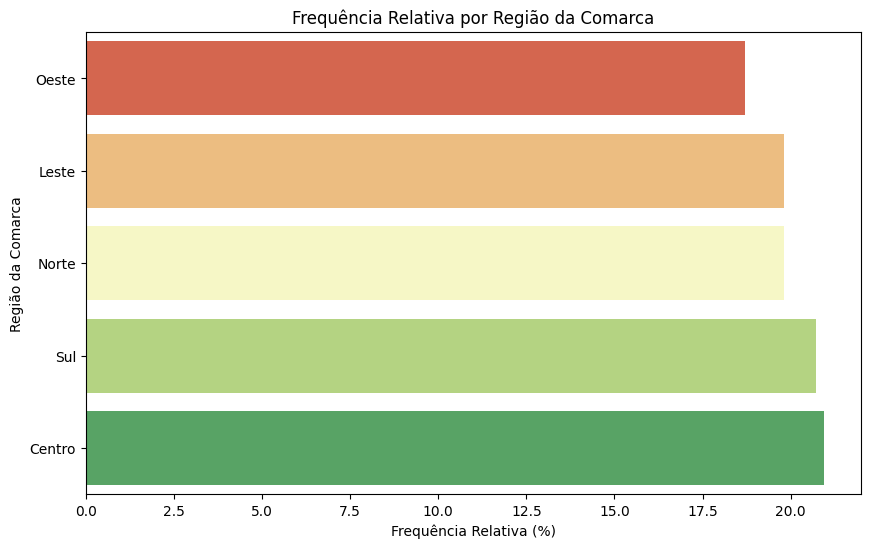

In [124]:
plotar_grafico_comarca(tabela_frequencia_comarca)


### 6.3 Tabela de Frequência: Tipo de Estratégia (variável categórica)

In [125]:
# Calcula a Frequência Absoluta para a coluna 'tipo_estrategia'
freq_absoluta_estrategia = df_legal['tipo_estrategia'].value_counts().sort_index()

# Calcula a Frequência Relativa (em %) para a coluna 'tipo_estrategia' abrangendo duas casas decimais
freq_relativa_estrategia = (df_legal['tipo_estrategia'].value_counts(normalize=True).sort_index() * 100).round(2)

# Calcula a Frequência Acumulada (em %) abrangendo duas casas decimais
freq_acumulada_estrategia = freq_relativa_estrategia.cumsum().round(2)

# Cria um DataFrame para reunir todas as frequências
tabela_frequencia_estrategia = pd.DataFrame({
    'Frequência Absoluta': freq_absoluta_estrategia,
    'Frequência Relativa (%)': freq_relativa_estrategia,
    'Frequência Acumulada (%)': freq_acumulada_estrategia
})

# Mostrando a tabela de frequência com frequências relativas e acumuladas arredondadas
display(tabela_frequencia_estrategia)

,Frequência Absoluta,Frequência Relativa (%),Frequência Acumulada (%)
tipo_estrategia,,,
Estrategia A,156,34.74,34.74
Estrategia B,135,30.07,64.81
Estrategia C,158,35.19,100.00


### 6.3.1 Gráfico da Tabela de Frequência de Tipo de Estratégia (variável categórica)

In [126]:
#Cria função para o gráfico de tipo de estratégia
def plotar_grafico_estrategia(tabela_frequencia_estrategia):
 
    # Ordena 'tabela_frequencia' pela 'Frequência Relativa (%)'
    grafico_estrategia = tabela_frequencia_estrategia.sort_values('Frequência Relativa (%)')

    # Cria o gráfico de barras horizontal
    plt.figure(figsize=(10, 6))
    sns.barplot(y=grafico_estrategia.index, x='Frequência Relativa (%)', data=grafico_estrategia, 
                palette=sns.color_palette("RdYlGn", len(grafico_estrategia)))
    plt.title('Frequência Relativa por Tipo de Estratégia')
    plt.ylabel('Tipo de Estratégia')
    plt.xlabel('Frequência Relativa (%)')
    plt.show()

# Exemplo de uso:
# plotar_grafico_estrategia(tabela_frequencia_estrategia)

/var/folders/gm/hs1ypf6d2q5_q207hcj6qw0w0000gn/T/ipykernel_16060/3567053085.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=grafico_estrategia.index, x='Frequência Relativa (%)', data=grafico_estrategia,


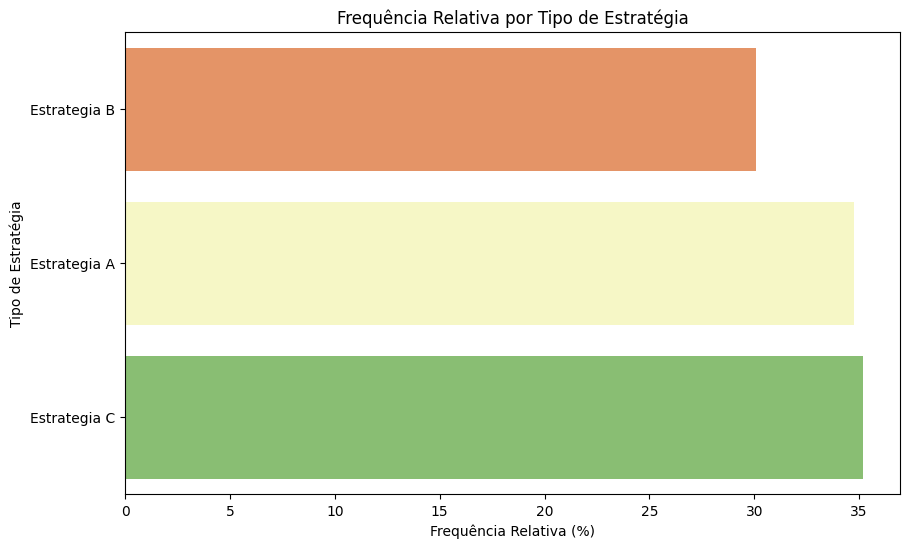

In [127]:
plotar_grafico_estrategia(tabela_frequencia_estrategia)

### 6.4 Medidas Resumo - Data de Julgamento

In [128]:
# Verifica o intervalo temporal
df_legal ['data_julgamento']

0     2019-07-01
1     2019-07-01
2     2019-07-02
3     2019-07-02
4     2019-07-03
         ...    
444   2019-12-29
445   2019-12-30
446   2019-12-30
447   2019-12-31
448   2019-12-31
Name: data_julgamento, Length: 449, dtype: datetime64[ns]

### 6.4.1 Tabela de Frequência: Data de Julgamento

In [129]:
#Cria tabela de frequencia por mes 


# Ajustando as datas para o primeiro dia do mês para agrupamento mensal
df_legal['mes_julgamento'] = df_legal['data_julgamento'].apply(lambda x: x.replace(day=1))

# Agrupando por mês e sentença, e contando as ocorrências
tabela_frequencia_por_mes = df_legal.groupby(['mes_julgamento', 'sentenca']).size().unstack(fill_value=0)

# Total acumulado de cada sentença ao longo de todos os meses
total_acumulado_por_sentenca = tabela_frequencia_por_mes.sum(axis=0)

# Calculando a frequência relativa em relação ao total acumulado de cada classe de sentença
frequencia_relativa_data = tabela_frequencia_por_mes.div(total_acumulado_por_sentenca, axis=1) * 100

# Calculando a frequência relativa cumulativa em relação ao total acumulado
frequencia_acumulada_data = frequencia_relativa_data.cumsum()

# Arredondando os valores para duas casas decimais
frequencia_relativa_data = frequencia_relativa_data.round(2)
frequencia_acumulada_data = frequencia_acumulada_data.round(2)

# Combinando as tabelas em uma única tabela para visualização
tabela_frequencia_data = pd.concat([tabela_frequencia_por_mes, frequencia_relativa_data, frequencia_acumulada_data], axis=1, keys=['Absoluta', 'Relativa (%)', 'Acumulada (%)'])

# Exibindo a tabela combinada
print("Tabela Combinada de Frequências por Mês:")
display(tabela_frequencia_data)



Tabela Combinada de Frequências por Mês:


Absoluta     Relativa (%)        Acumulada (%)        
sentenca              0   1            0      1             0       1
mes_julgamento                                                       
2019-07-01           38  41         15.2  20.60          15.2   20.60
2019-08-01           45  49         18.0  24.62          33.2   45.23
2019-09-01           56  27         22.4  13.57          55.6   58.79
2019-10-01           37  39         14.8  19.60          70.4   78.39
2019-11-01           35  20         14.0  10.05          84.4   88.44
2019-12-01           39  23         15.6  11.56         100.0  100.00

### 6.4.2 Gráfico da Frequência Relativa da Tabela de Frequência: Data de Julgamento 

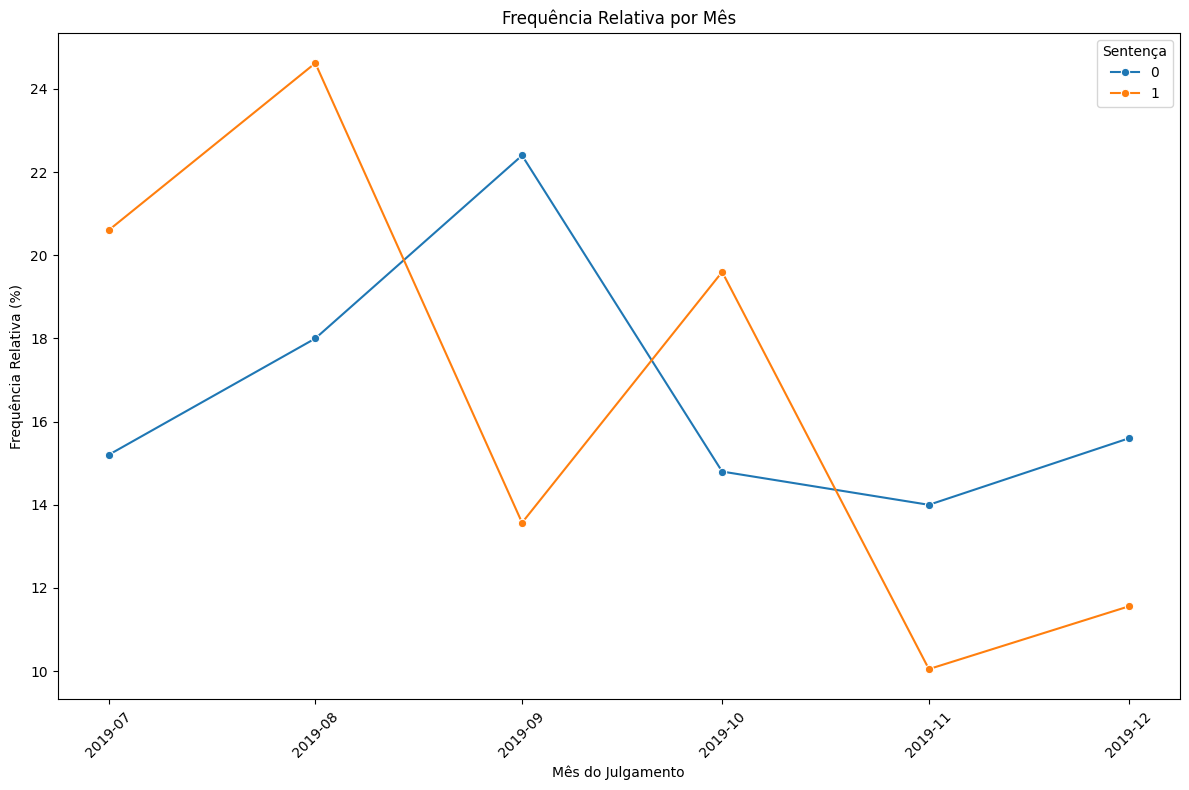

In [130]:
# Função para plotar o gráfico de frequência relativa cumulativa por data

def grafico_data_freq_relativa(tabela_frequencia_data):
    # Considera apenas a parte da frequência relativa cumulativa
    data_plot = tabela_frequencia_data['Relativa (%)'].reset_index()

    # Derretendo o DataFrame para o formato longo, adequado para o sns.lineplot
    data_plot_melt = pd.melt(data_plot, id_vars=['mes_julgamento'], 
                             var_name='Sentença', value_name='Frequência Relativa (%)')

    # Cria o gráfico de linha
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=data_plot_melt, x='mes_julgamento', y='Frequência Relativa (%)', hue='Sentença', marker='o')

    plt.title('Frequência Relativa por Mês')
    plt.xlabel('Mês do Julgamento')
    plt.ylabel('Frequência Relativa (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Sentença')
    plt.tight_layout()
    plt.show()

# Chamando a função com o DataFrame adequado
grafico_data_freq_relativa(tabela_frequencia_data)

### **<<<Aparentemente, os meses 09, 11 e 12 merecem atenção visto que indicaram diferenças entre as sentenças com valores resultantes desfavoráveis ao Banco, respectivamente, 8.82%, 3.94% e 4.03%>>>**

### 6.4.3 Gráfico da Frequência Acumulada da Tabela de Frequência: Data de Julgamento 

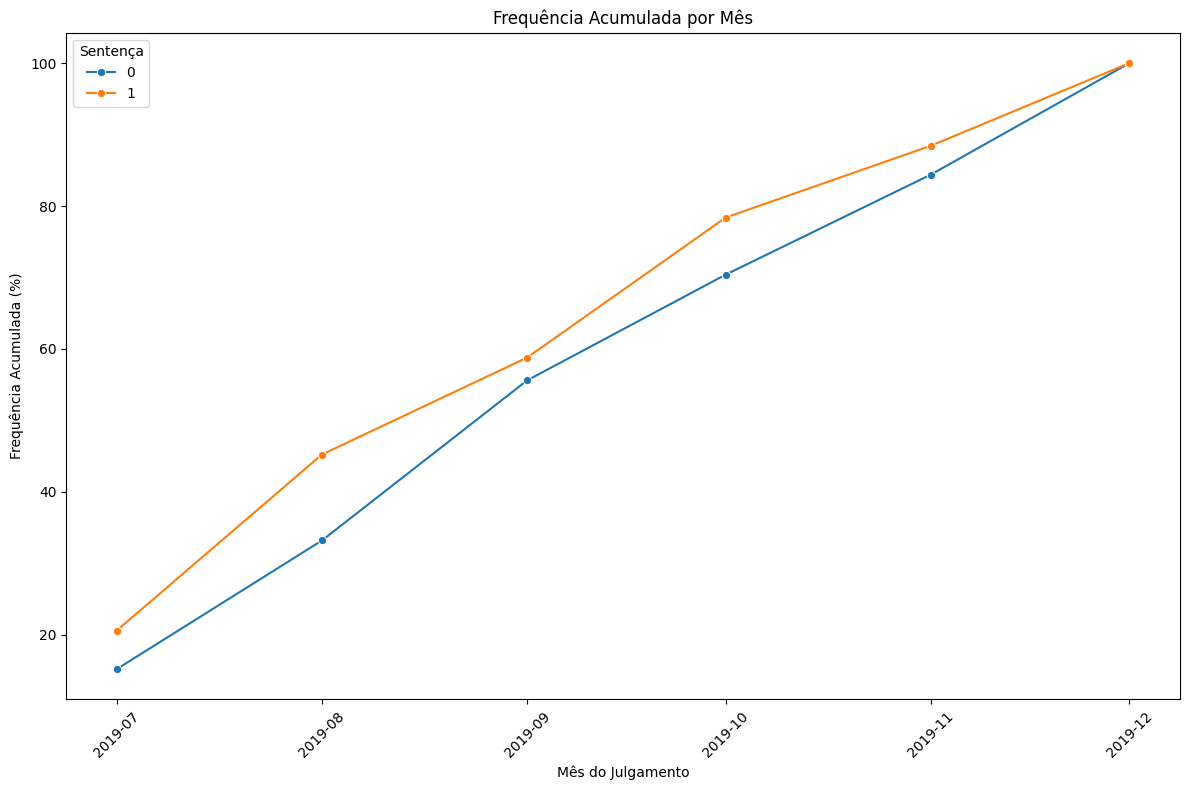

In [131]:
# Função para plotar o gráfico de frequência relativa cumulativa por data

def grafico_data_freq_acumulada(tabela_frequencia_data):
    # Considera apenas a parte da frequência relativa cumulativa
    data_plot = tabela_frequencia_data['Acumulada (%)'].reset_index()

    # Derretendo o DataFrame para o formato longo, adequado para o sns.lineplot
    data_plot_melt = pd.melt(data_plot, id_vars=['mes_julgamento'], 
                             var_name='Sentença', value_name='Frequência Acumulada (%)')

    # Cria o gráfico de linha
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=data_plot_melt, x='mes_julgamento', y='Frequência Acumulada (%)', hue='Sentença', marker='o')

    plt.title('Frequência Acumulada por Mês')
    plt.xlabel('Mês do Julgamento')
    plt.ylabel('Frequência Acumulada (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Sentença')
    plt.tight_layout()
    plt.show()

# Chamando a função com o DataFrame adequado
grafico_data_freq_acumulada(tabela_frequencia_data)



### 6.5 Medidas Resumo da Taxa Contratada

### 6.5.1 Histograma

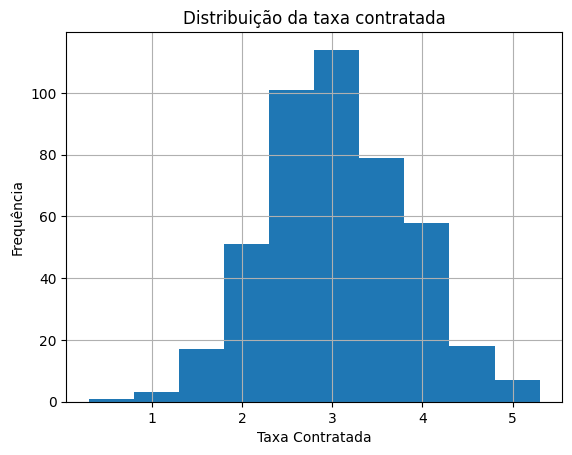

In [132]:
# Histograma para 'taxa_contratada'
df_legal['taxa_contratada'].hist()
plt.title('Distribuição da taxa contratada')
plt.xlabel('Taxa Contratada')
plt.ylabel('Frequência')
plt.show()

# Para exibir: df_legal['taxa_contratada'].hist()

### 6.5.2 Bloxplot

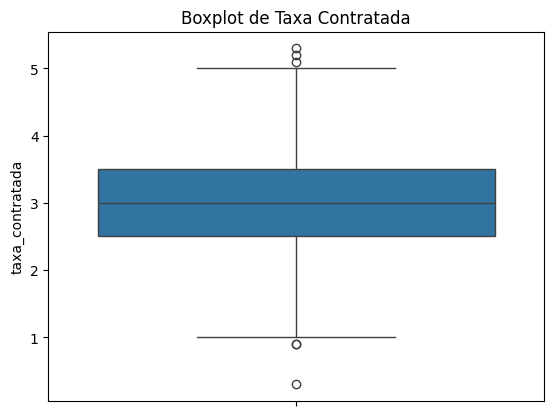

In [133]:
# Boxplot vertical (y=) bloxplot horizontal (x=)
sns.boxplot(y=df_legal['taxa_contratada'])

# Configura o título do gráfico
plt.title('Boxplot de Taxa Contratada')

# Mostra o gráfico
plt.show()


### 6.5.2.1 Outliers (Bloxplot)

In [134]:
# Calcula o IQR
Q1 = df_legal['taxa_contratada'].quantile(0.25)
Q3 = df_legal['taxa_contratada'].quantile(0.75)
IQR = Q3 - Q1

# Calcula o limite superior e inferior para identificar outliers
legal_limite_superior = Q3 + 1.5 * IQR
legal_limite_inferior = Q1 - 1.5 * IQR

# Identifica os outliers
legal_outliers_sup = df_legal[df_legal['taxa_contratada'] > legal_limite_superior]
legal_outliers_inf = df_legal[df_legal['taxa_contratada'] < legal_limite_inferior]

# Imprime resultados
display("Outliers acima do limite superior:")
display(legal_limite_superior)
display("Outliers abaixo do limite inferior:")
display(legal_limite_inferior)
display(legal_outliers_sup)
display(legal_outliers_inf)

'Outliers acima do limite superior:'

5.0

'Outliers abaixo do limite inferior:'

1.0

,sentenca,data_julgamento,regiao_comarca,tipo_estrategia,taxa_contratada,valor_indenizacao,mes_julgamento
9,0,2019-07-05,Leste,Estrategia C,5.2,3.309,2019-07-01
108,1,2019-08-11,Leste,Estrategia C,5.1,0.000,2019-08-01
238,0,2019-09-25,Oeste,Estrategia A,5.3,3.334,2019-09-01


,sentenca,data_julgamento,regiao_comarca,tipo_estrategia,taxa_contratada,valor_indenizacao,mes_julgamento
107,1,2019-08-10,Sul,Estrategia B,0.3,0.0,2019-08-01
261,1,2019-10-02,Sul,Estrategia B,0.9,0.0,2019-10-01
421,1,2019-12-18,Sul,Estrategia B,0.9,0.0,2019-12-01


### 6.5.2.2 Imprime Quartis 3 e 1

In [135]:
# Visualiza intervalos entre limite inferior e Q1 e limite superior e Q3
display("Quartil 3 (até 75%):")
display(Q3)
display("Quartil 1 (até 25%):")
display(Q1)

'Quartil 3 (até 75%):'

3.5

'Quartil 1 (até 25%):'

2.5

### 6.5.2.3 Média da Taxa de Contratação: Geral; >Q3; <Q1

In [136]:
# Analisa taxa geral
taxa_geral = df_legal ["taxa_contratada"].mean()

# Analisa intervalo entre limite inferior e Q1 e limite superior e Q3
taxa_maior_q3 = df_legal [df_legal['taxa_contratada'] > Q3]
taxa_menor_q1 = df_legal[df_legal['taxa_contratada'] < Q1]

# Cria a média dos intervalos entre limite inferior e Q1 e limite superior e Q3
media_taxa_maior_q3 = taxa_maior_q3['taxa_contratada'].mean()
media_taxa_menor_q1 = taxa_menor_q1['taxa_contratada'].mean()

# Define resultado das médias calculadas a variáveis
resultados_media_taxas = {
    'Media taxa geral contratada': taxa_geral,
    'Media taxa maior que Q3': media_taxa_maior_q3,
    'Media taxa menor que Q1': media_taxa_menor_q1
    }

resultados_media_taxas

{'Media taxa geral contratada': 2.997104677060134,
 'Media taxa maior que Q3': 4.039449541284404,
 'Media taxa menor que Q1': 2.003669724770642}

### 6.5.2.4 Média da Taxa de Contratação: Geral; >Q3; <Q1 por ganho de causa (Sentença 1)

In [137]:
#Filtra taxa contratada com sentença 1
df_sentenca_1 = df_legal[df_legal["sentenca"] == 1]

# Calcula a média geral da taxa_contratada para sentenças = 1
taxa_geral_sentenca_1 = df_sentenca_1["taxa_contratada"].mean()

# Calcula Q1 e Q3 para o subconjunto onde sentenca = 1
Q3_sentenca_1 = df_sentenca_1['taxa_contratada'].quantile(0.75)
Q1_sentenca_1 = df_sentenca_1['taxa_contratada'].quantile(0.25)

# Filtra dentro de df_sentenca_1 para obter as taxas maiores que Q3 e menores que Q1
tax_maiorq3_sentenca1 = df_sentenca_1[df_sentenca_1['taxa_contratada'] > Q3_sentenca_1]
tax_menorq1_sentenca1 = df_sentenca_1[df_sentenca_1['taxa_contratada'] < Q1_sentenca_1]

# Calcula as médias para esses novos subconjuntos
media_taxq3_sentenca1 = tax_maiorq3_sentenca1 ['taxa_contratada'].mean()
media_taxq1_sentenca1 = tax_menorq1_sentenca1['taxa_contratada'].mean()

# Define o resultado das médias calculadas para variáveis, agora focado em sentenca = 1
resultados_media_tax_sentenca1 = {
    'Media taxa geral contratada (sentenca=1)': taxa_geral_sentenca_1,
    'Media taxa maior que Q3 (sentenca=1)': media_taxq3_sentenca1,
    'Media taxa menor que Q1 (sentenca=1)': media_taxq1_sentenca1
}

resultados_media_tax_sentenca1



{'Media taxa geral contratada (sentenca=1)': 2.7562814070351758,
 'Media taxa maior que Q3 (sentenca=1)': 3.6480000000000006,
 'Media taxa menor que Q1 (sentenca=1)': 1.784782608695652}

### 6.6 Medidas Resumo do Valor de Indenização

### 6.6.1 Média

In [138]:
# Calcula a média do valor de indenização, excluindo os valores iguais a 0
media_indenizacao = df_legal[df_legal['valor_indenizacao'] != 0]['valor_indenizacao'].mean()

print(media_indenizacao)


3.050228


### 6.6.2 Mediana

In [139]:
# Calcula a mediana do valor de indenização, excluindo os valores iguais a 0
mediana_indenizacao = df_legal[df_legal['valor_indenizacao'] != 0]['valor_indenizacao'].median()

print(mediana_indenizacao)

3.066


### 6.6.3 Desvio Padrão

In [140]:
# Calcula o desvio do valor de indenização, excluindo os valores iguais a 0
desvio_indenizacao = df_legal[df_legal['valor_indenizacao'] != 0]['valor_indenizacao'].std()

print(desvio_indenizacao)

0.4916913682611176


### 6.6.4 Mínimo 

In [141]:
# Exibe o mínimo do valor de indenização, excluindo os valores iguais a 0
minimo_indenizacao = df_legal[df_legal['valor_indenizacao'] != 0]['valor_indenizacao'].min()

print(minimo_indenizacao)

1.583


### 6.6.5 Máximo 

In [142]:
# Exibe o máximo do valor de indenização, excluindo os valores iguais a 0
max_indenizacao = df_legal[df_legal['valor_indenizacao'] != 0]['valor_indenizacao'].max()

print(f"{max_indenizacao:.3f}")

4.380


### 6.6.6 Teste de Hipóteses: Teste T para 1 População

### 6.6.7 Hipótese Nula (H0) e Hipótese Alternativa (H1)
H0: a média do valor de indenização é = R$3.050,00

H1: a média do valor de indenização é =! R$3.050,00

### 6.6.8 Aplicação do Teste T para 1 População

In [143]:
# Dados da amostra: != 0
amostra_indenizacao = df_legal[df_legal['valor_indenizacao'] != 0]['valor_indenizacao']

# Calcula e exibe o tamanho da amostra
tamanho_amostra_indenizacao = amostra_indenizacao.size
print(f"Tamanho da amostra com numeros != 0: {tamanho_amostra_indenizacao}")
print(f"Tamanho da amostra para o teste: {tamanho_amostra_indenizacao-150}")
# Média da população para comparação
media_indenizacao = 3.050

# Realiza o teste T para uma amostra (stats realiza internamente a operação com o desvio padrão)
t_statistic, p_value = stats.ttest_1samp(amostra_indenizacao, media_indenizacao)

display(f"T-statistic: {t_statistic:.2f}, P-value: {p_value:.3f}")


Tamanho da amostra com numeros != 0: 250
Tamanho da amostra para o teste: 100


'T-statistic: 0.01, P-value: 0.994'

### 6.6.9 Intervalo de Confiança com Coeficiente de Confiança de 95% 

In [144]:
# Com base nos seguintes objetos: amostra_indenizacao, tamanho_amostra_indenizacao, e media_indenizacao

# Calcula média e desvio padrão da amostra
media_amostral = np.mean(amostra_indenizacao)
desvio_padrao_amostral = np.std(amostra_indenizacao, ddof=1)  # ddof=1 fornece a estimativa correta do desvio padrão da população

# Calcula o valor t crítico para 95% de confiança e n-1 graus de liberdade
t_critico = stats.t.ppf(0.975, tamanho_amostra_indenizacao - 1)

# Calcula a margem de erro
margem_erro = t_critico * (desvio_padrao_amostral / np.sqrt(tamanho_amostra_indenizacao))

# Calcula o intervalo de confiança
limite_inferior_confianca = media_amostral - margem_erro
limite_superior_confianca = media_amostral + margem_erro

# Exibe o intervalo de confiança
print(f"Intervalo de Confiança de 95% para a Média Amostral: ({limite_inferior_confianca:.3f}, {limite_superior_confianca:.3f})")

Intervalo de Confiança de 95% para a Média Amostral: (2.989, 3.111)


### 6.6.10 Margem de Erro 

In [145]:
# Exibe a margem de erro
print(f"Margem de Erro: {margem_erro:.3f}")

Margem de Erro: 0.061


### 6.6.11 Resultado e Interpretação do Teste de Hipóteses Aplicado

Com valor-P acima de 0.05 não há evidências estatísticas suficientes para rejeitar a hipótese nula, ou seja, não podemos afirmar que a média amostral não seja significativamente equivalente à média da população conhecida. Adicionalmente, com 95% de intervalo de confiança e com margem de erro de 0.061, pode-se afirmar que em cada 100 intervalos, 95 deles o valor da indenização estará entre 2.942 e 3.159.

### 6.7 Ganhos de Causa (Sentença 1)

### 6.7.1 Distribuição de Ganho de Causa Geral

In [146]:
# Calcula a contagem absoluta de valores
sentenca_taxa_abs = df_legal["sentenca"].value_counts()

# Calcula a contagem relativa (em porcentagem) de valores
sentenca_taxa_rel = df_legal["sentenca"].value_counts(normalize=True).map("{:.2%}".format)

# Exibe os resultados
display("Contagem:", sentenca_taxa_abs)
display("Proporção:", sentenca_taxa_rel)

'Contagem:'

sentenca
0    250
1    199
Name: count, dtype: int64

'Proporção:'

sentenca
0    55.68%
1    44.32%
Name: proportion, dtype: object

### 6.7.2 Distribuição de Ganho de Causa com Taxas Contratadas > 3.5%

In [147]:
# Filtra 'df_legal' para incluir somente valores onde 'taxa_contratada' é maior que 3.5
filtro_taxa_maiorq3 = df_legal[df_legal['taxa_contratada'] > 3.5]

# Agrupa por 'sentenca' e conta as ocorrências
taxa_maiorq3_sentenca = filtro_taxa_maiorq3.groupby('sentenca').size()

# Calcula os valores percentuais das ocorrências para cada valor de 'sentenca'
percentual_maiorq3_sentenca = (taxa_maiorq3_sentenca / filtro_taxa_maiorq3.groupby('sentenca').size().sum()) * 100

# Exibe resultado
resultado_taxa_maiorq3 = pd.DataFrame({
    'Número de ocorrências com taxa > 3.5': taxa_maiorq3_sentenca,
    'Percentual (%)': percentual_maiorq3_sentenca.round(2)})

display(resultado_taxa_maiorq3)



,Número de ocorrências com taxa > 3.5,Percentual (%)
sentenca,,
0,84,77.06
1,25,22.94


### 6.7.3 Distribuição de ganhos de causa por Comarca

In [148]:
# Agrupa distribuição da região da comarca por sentença
sentenca_comarca_abs0 = df_legal['regiao_comarca'].groupby(df_legal['sentenca']
                                                         [df_legal ['sentenca']== 0]).value_counts()
sentenca_comarca_abs1 = df_legal['regiao_comarca'].groupby(df_legal['sentenca']
                                                        [df_legal ['sentenca']== 1]).value_counts()

sentenca_comarca_rel0 = df_legal['regiao_comarca'].groupby(df_legal['sentenca']
                                                        [df_legal ['sentenca']== 0]).value_counts(normalize=True).map("{:.2%}".format)
sentenca_comarca_rel1 = df_legal['regiao_comarca'].groupby(df_legal['sentenca']
                                                        [df_legal ['sentenca']== 1]).value_counts(normalize=True).map("{:.2%}".format)


# Exibe resultado
display (sentenca_comarca_abs0)
display (sentenca_comarca_rel0)
display (sentenca_comarca_abs1)
display (sentenca_comarca_rel1)


sentenca  regiao_comarca
0.0       Centro            58
          Norte             52
          Leste             47
          Sul               47
          Oeste             46
Name: count, dtype: int64

sentenca  regiao_comarca
0.0       Centro            23.20%
          Norte             20.80%
          Leste             18.80%
          Sul               18.80%
          Oeste             18.40%
Name: proportion, dtype: object

sentenca  regiao_comarca
1.0       Sul               46
          Leste             42
          Oeste             38
          Norte             37
          Centro            36
Name: count, dtype: int64

sentenca  regiao_comarca
1.0       Sul               23.12%
          Leste             21.11%
          Oeste             19.10%
          Norte             18.59%
          Centro            18.09%
Name: proportion, dtype: object

### 6.7.4 Distribuição de ganhos de causa por Estratégia

In [149]:
# Agrupa distribuição do tipo de estrategia por sentença
sentenca_estrategia_abs0 = df_legal['tipo_estrategia'].groupby(df_legal['sentenca']
                                                         [df_legal ['sentenca']== 0]).value_counts()
sentenca_estrategia_abs1 = df_legal['tipo_estrategia'].groupby(df_legal['sentenca']
                                                        [df_legal ['sentenca']== 1]).value_counts()

sentenca_estrategia_rel0 = df_legal['tipo_estrategia'].groupby(df_legal['sentenca']
                                                        [df_legal ['sentenca']== 0]).value_counts(normalize=True).map("{:.2%}".format)
sentenca_estrategia_rel1 = df_legal['tipo_estrategia'].groupby(df_legal['sentenca']
                                                        [df_legal ['sentenca']== 1]).value_counts(normalize=True).map("{:.2%}".format)


# Exibe resultado
display (sentenca_estrategia_abs0)
display (sentenca_estrategia_rel0)
display (sentenca_estrategia_abs1)
display (sentenca_estrategia_rel1)

sentenca  tipo_estrategia
0.0       Estrategia A       94
          Estrategia C       93
          Estrategia B       63
Name: count, dtype: int64

sentenca  tipo_estrategia
0.0       Estrategia A       37.60%
          Estrategia C       37.20%
          Estrategia B       25.20%
Name: proportion, dtype: object

sentenca  tipo_estrategia
1.0       Estrategia B       72
          Estrategia C       65
          Estrategia A       62
Name: count, dtype: int64

sentenca  tipo_estrategia
1.0       Estrategia B       36.18%
          Estrategia C       32.66%
          Estrategia A       31.16%
Name: proportion, dtype: object

### 6.7.5 Distribuição de ganhos de causa por Taxa de Contratação - Dispersão por Classe

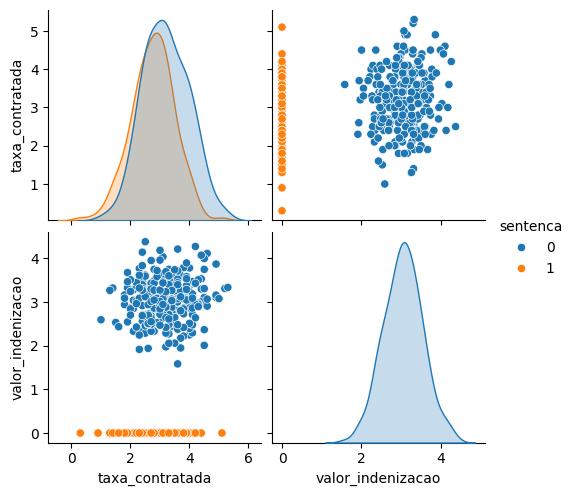

In [150]:
# Cria dispersão por classe 
sns.pairplot(df_legal,hue='sentenca')


### 6.7.6 Distribuição de Ganho de Causa por Taxa de Contratação - Matriz de Correlação

<Axes: >

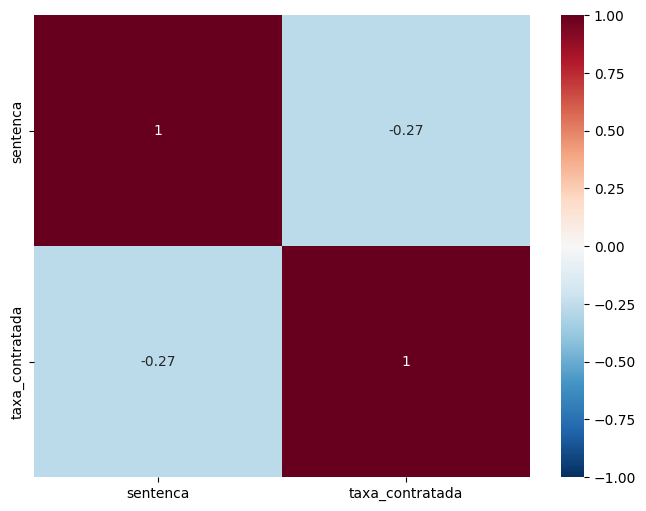

In [151]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(df_legal.drop('valor_indenizacao', axis=1).corr(numeric_only=True),
            cmap='RdBu_r',
            vmin=-1, vmax=1,
            annot=True)

### 6.7.7 Distribuição de Ganho de Causa por Taxa Contratada > 3.5 - Matriz de Correlação

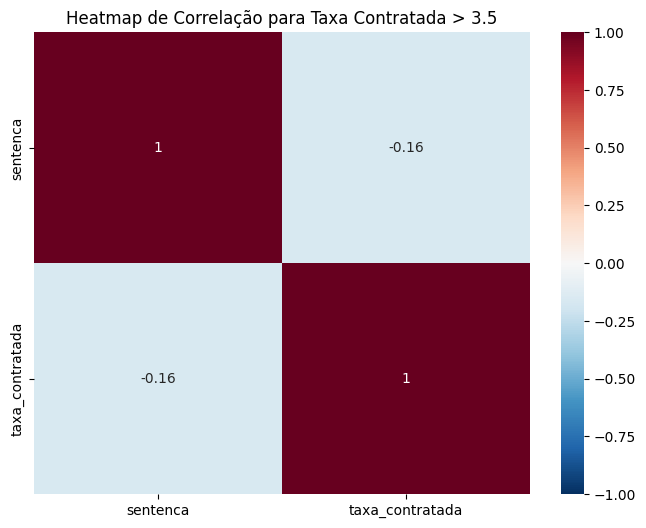

In [152]:
# Filtra 'df_legal' para incluir somente valores onde 'taxa_contratada' é maior que 3.5
filtro_taxa_maiorq3 = df_legal[df_legal['taxa_contratada'] > 3.5]

# Calcula a matriz de correlação para o DataFrame filtrado, excluindo a coluna 'valor_indenizacao'
matriz_correlacao = filtro_taxa_maiorq3.drop('valor_indenizacao', axis=1).corr(numeric_only=True)

# Cria o heatmap usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, cmap='RdBu_r', vmin=-1, vmax=1, annot=True)

# Define o título e ajusta a exibição
plt.title('Heatmap de Correlação para Taxa Contratada > 3.5')
plt.show()


### 7. APRENDIZADO DE MÁQUINA COM MÉTODO SUPERVISIONADO: ÁRVORE DE DECISÃO (DECISION TREE)

### 7.1 Exclui Variáveis para Preparar o Modelo

In [153]:
df_legal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sentenca           449 non-null    int64         
 1   data_julgamento    449 non-null    datetime64[ns]
 2   regiao_comarca     449 non-null    object        
 3   tipo_estrategia    449 non-null    object        
 4   taxa_contratada    449 non-null    float64       
 5   valor_indenizacao  449 non-null    float64       
 6   mes_julgamento     449 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 24.7+ KB


In [154]:
# Extraí o mês da coluna 'mes_julgamento'
df_legal['mes'] = df_legal['mes_julgamento'].dt.month

# Converte mes em variáveis dummy
mes_dummies = pd.get_dummies(df_legal['mes'], prefix='mes')

# Concatena as novas colunas dummy com o DataFrame original
df_legal_modelagem = pd.concat([df_legal, mes_dummies], axis=1)

# Exclui coluna mês de julgamento
df_legal_modelagem.drop(['mes_julgamento', 'mes'], axis=1, inplace=True)

# Exibe o novo DataFrame com as colunas dummy adicionadas
display(df_legal_modelagem.head())

,sentenca,data_julgamento,regiao_comarca,tipo_estrategia,taxa_contratada,valor_indenizacao,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,1,2019-07-01,Oeste,Estrategia C,3.1,0.000,True,False,False,False,False,False
1,1,2019-07-01,Norte,Estrategia C,2.5,0.000,True,False,False,False,False,False
2,0,2019-07-02,Sul,Estrategia A,4.0,2.247,True,False,False,False,False,False
3,1,2019-07-02,Sul,Estrategia B,2.6,0.000,True,False,False,False,False,False
4,1,2019-07-03,Oeste,Estrategia B,4.1,0.000,True,False,False,False,False,False


In [155]:
# Exclui variáveis para modelagem
prep_modelo = df_legal_modelagem.drop(['data_julgamento','valor_indenizacao'],  axis= 1)

In [156]:
# Exibe após exclusão
prep_modelo

,sentenca,regiao_comarca,tipo_estrategia,taxa_contratada,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,1,Oeste,Estrategia C,3.1,True,False,False,False,False,False
1,1,Norte,Estrategia C,2.5,True,False,False,False,False,False
2,0,Sul,Estrategia A,4.0,True,False,False,False,False,False
3,1,Sul,Estrategia B,2.6,True,False,False,False,False,False
4,1,Oeste,Estrategia B,4.1,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
444,1,Leste,Estrategia C,3.8,False,False,False,False,False,True
445,0,Centro,Estrategia C,3.3,False,False,False,False,False,True
446,0,Norte,Estrategia B,3.0,False,False,False,False,False,True
447,0,Leste,Estrategia A,3.1,False,False,False,False,False,True


### 7.2 Criação das Variáveis Categóricas em Dummies

In [157]:
# Cria variáveis dummies
modelo = pd.get_dummies(prep_modelo)

# Exibe as primeiras linhas do df transformado
display(modelo.head(2))

,sentenca,taxa_contratada,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12,regiao_comarca_Centro,regiao_comarca_Leste,regiao_comarca_Norte,regiao_comarca_Oeste,regiao_comarca_Sul,tipo_estrategia_Estrategia A,tipo_estrategia_Estrategia B,tipo_estrategia_Estrategia C
0,1,3.1,True,False,False,False,False,False,False,False,False,True,False,False,False,True
1,1,2.5,True,False,False,False,False,False,False,False,True,False,False,False,False,True


In [158]:
# Converte booleano para 0 e 1 
dt_modelo_1 = modelo.astype(int)

display(dt_modelo_1.head(10))


,sentenca,taxa_contratada,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12,regiao_comarca_Centro,regiao_comarca_Leste,regiao_comarca_Norte,regiao_comarca_Oeste,regiao_comarca_Sul,tipo_estrategia_Estrategia A,tipo_estrategia_Estrategia B,tipo_estrategia_Estrategia C
0,1,3,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,2,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,4,1,0,0,0,0,0,0,0,0,0,1,1,0,0
3,1,2,1,0,0,0,0,0,0,0,0,0,1,0,1,0
4,1,4,1,0,0,0,0,0,0,0,0,1,0,0,1,0
5,0,4,1,0,0,0,0,0,1,0,0,0,0,0,1,0
6,1,2,1,0,0,0,0,0,0,0,1,0,0,0,0,1
7,1,3,1,0,0,0,0,0,0,1,0,0,0,0,1,0
8,1,2,1,0,0,0,0,0,0,0,0,0,1,1,0,0
9,0,5,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [159]:
dt_modelo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   sentenca                      449 non-null    int64
 1   taxa_contratada               449 non-null    int64
 2   mes_7                         449 non-null    int64
 3   mes_8                         449 non-null    int64
 4   mes_9                         449 non-null    int64
 5   mes_10                        449 non-null    int64
 6   mes_11                        449 non-null    int64
 7   mes_12                        449 non-null    int64
 8   regiao_comarca_Centro         449 non-null    int64
 9   regiao_comarca_Leste          449 non-null    int64
 10  regiao_comarca_Norte          449 non-null    int64
 11  regiao_comarca_Oeste          449 non-null    int64
 12  regiao_comarca_Sul            449 non-null    int64
 13  tipo_estrategia_Estrategia A  449 n

### 7.3 Variável Resposta (Target) do Modelo e Variáveis Explicativas (Features)

In [160]:
# Target (variável resposta)
y = dt_modelo_1['sentenca']

# Features (variáveis explicativas)
x = dt_modelo_1.drop(['sentenca','mes_7', 'mes_8', 'regiao_comarca_Norte', 'tipo_estrategia_Estrategia A'],axis = 1)

# Exclusão de colunas para evitar o ruído no aprendizado

### 7.3.1 Separação das bases em treino e teste

In [161]:
# Particiona a base em 70% para Treino e 30% para Teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

### 7.4 Treinamento da Árvore de Decisão - sem regularização

In [162]:
dt_modelo_1 = DecisionTreeClassifier(max_depth=3, 
                                    random_state=42)
dt_modelo_1.fit(x, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

### 7.4.1 Aplicação do modelo treinado - sem regularização

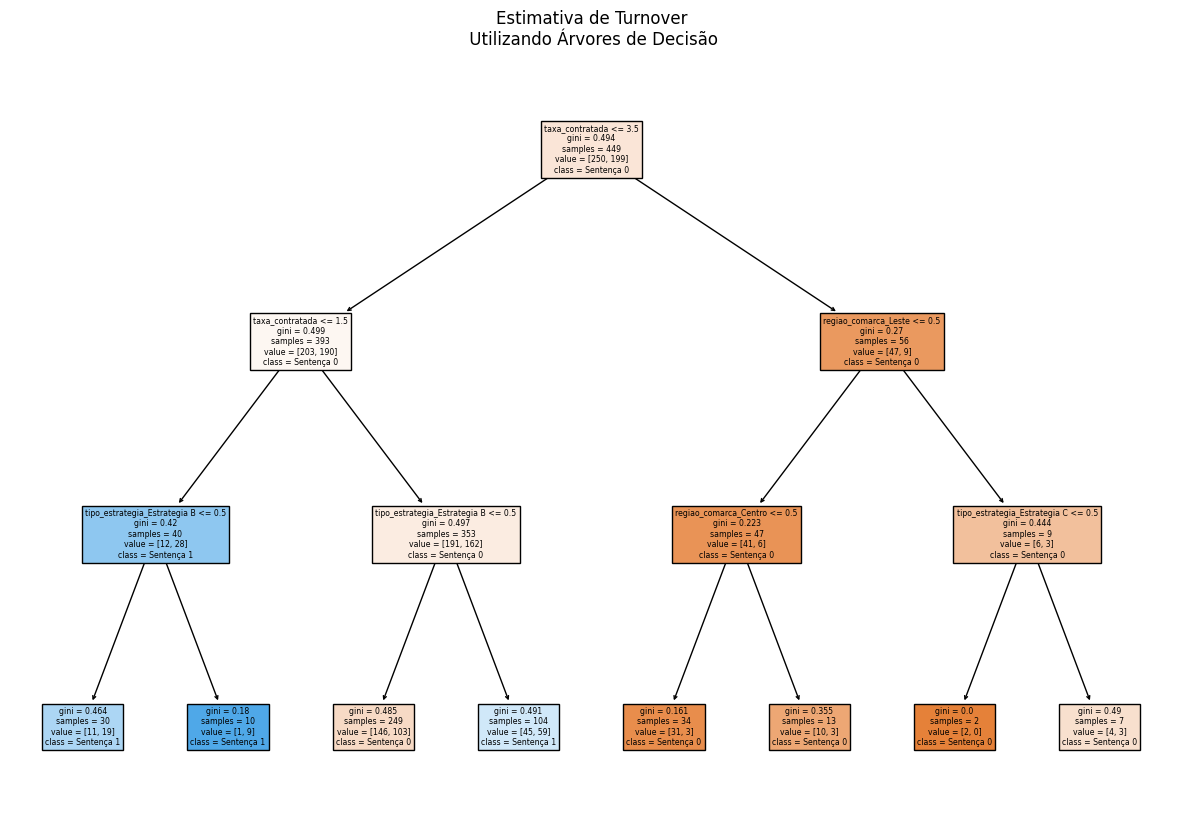

In [163]:
sns.reset_defaults()
%matplotlib inline
fig = plt.figure(figsize=(15,10))
features = list(x.columns)
tree.plot_tree(dt_modelo_1,
               feature_names=features, 
               class_names=['Sentença 0','Sentença 1'],
               filled=True);
plt.title("Estimativa de Turnover\n Utilizando Árvores de Decisão");

### 7.4.2 Função de desempenho do modelo treinado aplicada à árvore de decisão sem regularização

In [164]:
# Função para cálculo do KS
def ks_stat(y, y_pred):
    return ks_2samp(y_pred[y==1], y_pred[y!=1]).statistic



In [165]:
# Função para calcular métricas de desempenho
def calcula_desempenho(dt_modelo_1, x_treino, y_treino, x_teste, y_teste):
    
    # Predições
    ypred_treino = dt_modelo_1.predict(x_treino)
    ypred_proba_treino = dt_modelo_1.predict_proba(x_treino)[:, 1]

    ypred_teste = dt_modelo_1.predict(x_teste)
    ypred_proba_teste = dt_modelo_1.predict_proba(x_teste)[:, 1]
    
    
    #Calculando Acurácia 
    acuracia_treino = accuracy_score(y_treino, ypred_treino)
    accuracia_teste = accuracy_score(y_teste, ypred_teste)
    
    #Calculando ROC AUC
    roc_treino = roc_auc_score(y_treino, ypred_proba_treino)
    roc_teste = roc_auc_score(y_teste, ypred_proba_teste)

    # Calculando KS
    ks_treino = ks_2samp(y_treino, ypred_proba_treino).statistic
    ks_teste = ks_2samp(y_teste, ypred_proba_teste).statistic

    # Precisão, Recall e F1
    precision_treino = precision_score(y_treino, ypred_treino)
    precision_teste = precision_score(y_teste, ypred_teste)

    recall_treino = recall_score(y_treino, ypred_treino)
    recall_teste = recall_score(y_teste, ypred_teste)

    f1_score_treino = f1_score(y_treino, ypred_treino)
    f1_score_teste = f1_score(y_teste, ypred_teste)
    
    # Montando DataFrame de Desempenho
    desempenho_dt = pd.DataFrame({
        'Treino': [acuracia_treino, roc_treino, ks_treino, precision_treino, recall_treino, f1_score_treino],
        'Teste': [accuracia_teste, roc_teste, ks_teste, precision_teste, recall_teste, f1_score_teste]
    }, index=['Acurácia', 'AUROC', 'KS', 'Precision', 'Recall', 'F1'])

    desempenho_dt['Variação'] = round(desempenho_dt['Teste'] / desempenho_dt['Treino'] - 1, 2)
    return desempenho_dt


   

In [166]:
#Exibe resultado das métricas de desempenho
resultado_desempenho_dt = calcula_desempenho(dt_modelo_1, x_treino, y_treino, x_teste, y_teste)
display(resultado_desempenho_dt)

,Treino,Teste,Variação
Acurácia,0.630573,0.607407,-0.04
AUROC,0.637196,0.673178,0.06
KS,0.573248,0.503704,-0.12
Precision,0.580000,0.659091,0.14
Recall,0.439394,0.432836,-0.01
F1,0.500000,0.522523,0.05


### 7.4.3 Matriz de Confusão (Confusion Matrix) sobre modelo sem regularização

In [167]:

# Função para exibir matriz de confusão
def cm_sem_reg (dt_modelo_1, x_treino, y_treino, x_teste, y_teste):
  
    # Predições
    ypred_treino = dt_modelo_1.predict(x_treino)
    ypred_teste = dt_modelo_1.predict(x_teste)
    
    # Matriz de confusão
    cm_treino = confusion_matrix(y_treino, ypred_treino)
    cm_teste = confusion_matrix(y_teste, ypred_teste)
    
    # Plotando a matriz de confusão do treino
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
    sns.heatmap(cm_treino, annot=True, fmt="d", cmap='Blues')
    plt.title('Matriz de Confusão - Treino')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    
    # Plotando a matriz de confusão do teste
    plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
    sns.heatmap(cm_teste, annot=True, fmt="d", cmap='Greens')
    plt.title('Matriz de Confusão - Teste')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    
    plt.tight_layout()
    plt.show()

# Para usar a função:
# cm_sem_reg (dt_modelo_1, x_treino, y_treino, x_teste, y_teste)


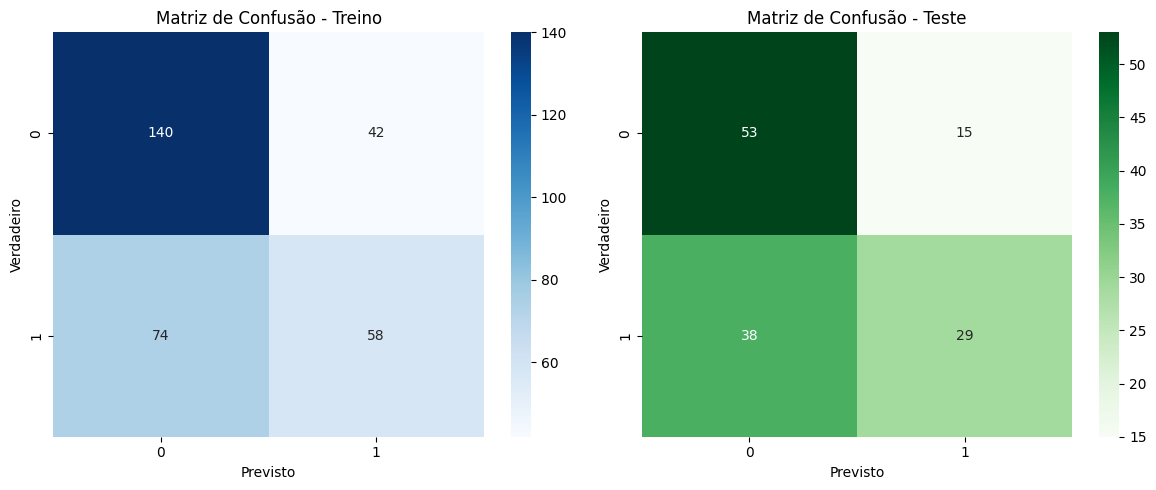

In [168]:
cm_sem_reg (dt_modelo_1, x_treino, y_treino, x_teste, y_teste)

In [169]:
x_treino.shape


(314, 11)

In [170]:
y_teste.shape

(135,)

### 7.5 Treinamento da Árvore de Decisão - com regularização


In [171]:
# Particiona a base em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

In [172]:
dt_modelo_1 = DecisionTreeClassifier(max_depth=4,
                                     min_samples_leaf= 30,
                                     min_impurity_decrease =0.0,
                                     max_features = None,
                                     criterion ='gini',
                                     splitter = 'best',
                                     class_weight = 'balanced',
                                     ccp_alpha = 0.0,
                                     random_state=42)
dt_modelo_1.fit(x, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=30, random_state=42)

### 7.5.1 Aplicação do modelo treinado com regularização

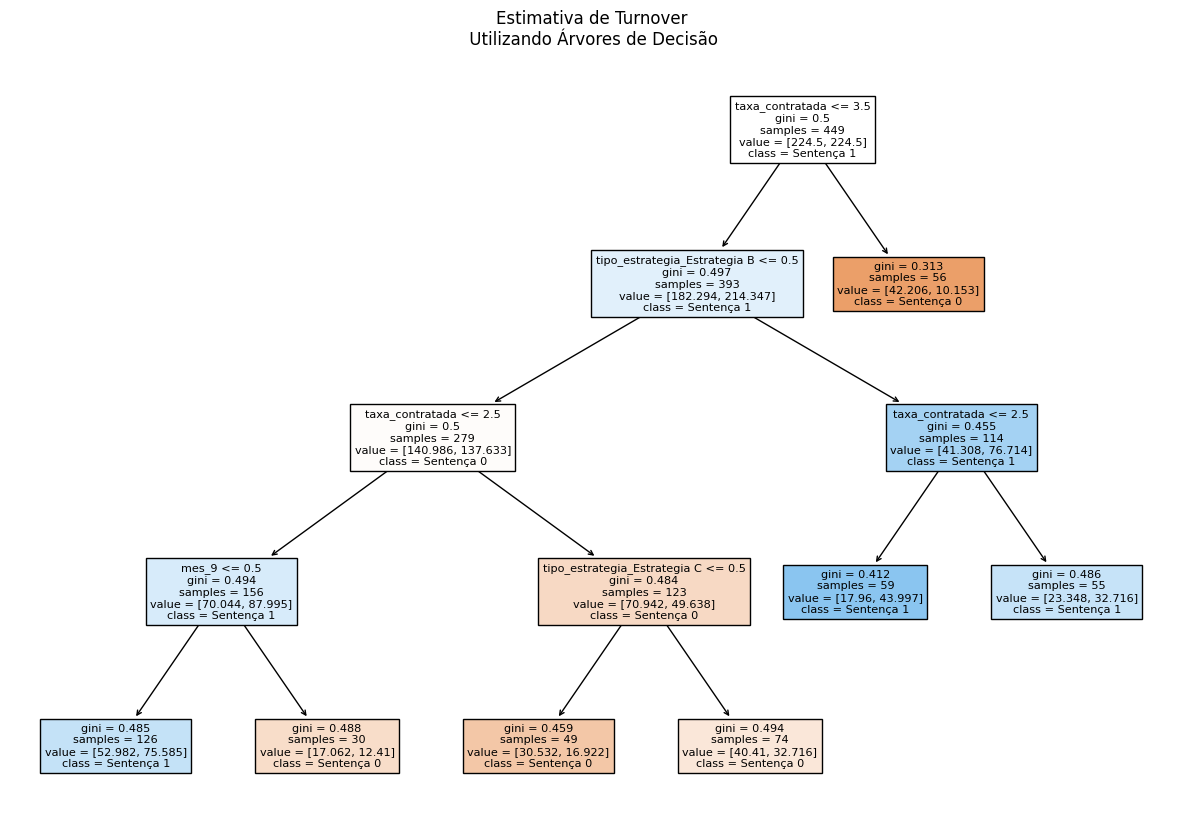

In [173]:
sns.reset_defaults()
%matplotlib inline
fig = plt.figure(figsize=(15,10))
features = list(x.columns)
tree.plot_tree(dt_modelo_1,
               feature_names=features, 
               class_names=['Sentença 0','Sentença 1'],
               filled=True);
plt.title("Estimativa de Turnover\n Utilizando Árvores de Decisão");

### 7.5.2 Função de desempenho do modelo treinado aplicada à árvore de decisão com regularização

In [174]:
#Exibe resultado das métricas de desempenho
resultado_desempenho_dt2 = calcula_desempenho(dt_modelo_1, x_treino, y_treino, x_teste, y_teste)
display(resultado_desempenho_dt2)

,Treino,Teste,Variação
Acurácia,0.630573,0.607407,-0.04
AUROC,0.684066,0.620391,-0.09
KS,0.579618,0.503704,-0.13
Precision,0.548780,0.592105,0.08
Recall,0.681818,0.671642,-0.01
F1,0.608108,0.629371,0.03


### **<<<Por ser importante ao negócio identificar e classificar verdadeiros positivos corretamente, mitigando ao máximo os custos dos falsos positivos e dos faloss negativos, decide-se pela métrica de desempenho F1 Score>>**.

### 7.5.3 Matriz de Confusão (Confusion Matrix) sobre modelo com regularização

In [175]:

# Função para exibir matriz de confusão
def cm_com_reg (dt_modelo_1, x_treino, y_treino, x_teste, y_teste):
  
    # Predições
    ypred_treino = dt_modelo_1.predict(x_treino)
    ypred_teste = dt_modelo_1.predict(x_teste)
    
    # Matriz de confusão
    cm_treino = confusion_matrix(y_treino, ypred_treino)
    cm_teste = confusion_matrix(y_teste, ypred_teste)
    
    # Plotando a matriz de confusão do treino
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
    sns.heatmap(cm_treino, annot=True, fmt="d", cmap='Blues')
    plt.title('Matriz de Confusão - Treino')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    
    # Plotando a matriz de confusão do teste
    plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
    sns.heatmap(cm_teste, annot=True, fmt="d", cmap='Greens')
    plt.title('Matriz de Confusão - Teste')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    
    plt.tight_layout()
    plt.show()

# Para usar a função, você pode simplesmente chamar:
# cm_com_reg (dt_modelo_1, x_treino, y_treino, x_teste, y_teste)

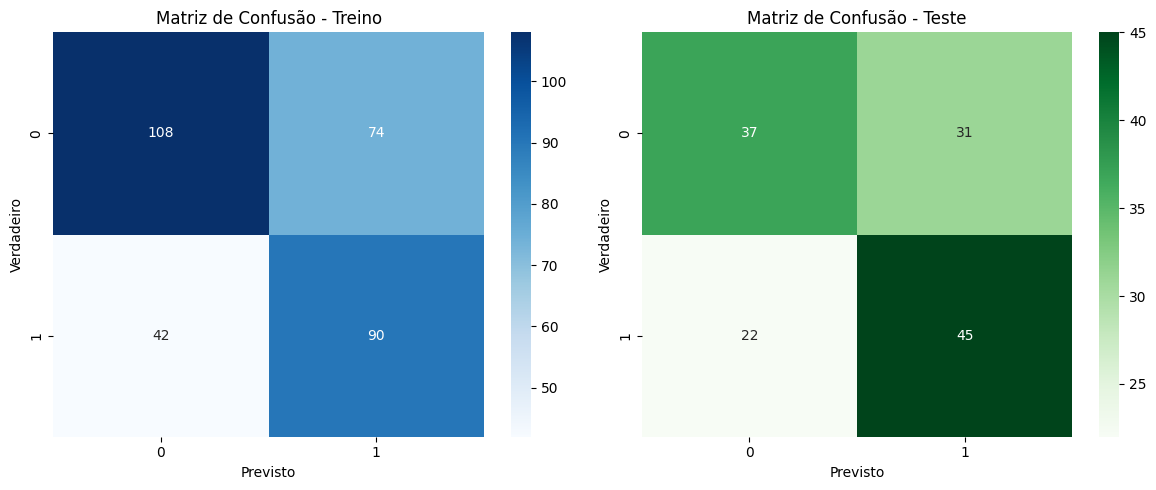

In [176]:
cm_com_reg (dt_modelo_1, x_treino, y_treino, x_teste, y_teste)

In [177]:
x_treino.shape

(314, 11)

In [178]:
y_teste.shape

(135,)

### **7.5.4 COMPARAÇÃO DOS MODELOS SEM REGULARIZAÇÃO E COM REGULARIZAÇÃO**

In [179]:
# modelo sem regularização
resultado_desempenho_dt

,Treino,Teste,Variação
Acurácia,0.630573,0.607407,-0.04
AUROC,0.637196,0.673178,0.06
KS,0.573248,0.503704,-0.12
Precision,0.580000,0.659091,0.14
Recall,0.439394,0.432836,-0.01
F1,0.500000,0.522523,0.05


In [180]:
#modelo com regularização
resultado_desempenho_dt2

,Treino,Teste,Variação
Acurácia,0.630573,0.607407,-0.04
AUROC,0.684066,0.620391,-0.09
KS,0.579618,0.503704,-0.13
Precision,0.548780,0.592105,0.08
Recall,0.681818,0.671642,-0.01
F1,0.608108,0.629371,0.03


### 7.6 ÁRVORE DE DECISÃO - F1 SCORE - VALIDAÇÃO CRUZADA (K-FOLD)

In [181]:
#Percentual da base que fica para teste é 1/k. Se k = 5 então o particionamento: 80% para Treino e 20% para Teste
particoes_legal = KFold(n_splits=5, shuffle= True, random_state=42) 

In [182]:
# Exibe os índices do DataFrame X com 10 linhas
for treino_index, teste_index in particoes_legal.split(x.head(10)):
    print(treino_index, len(treino_index), teste_index, len(teste_index)) 

[0 2 3 4 5 6 7 9] 8 [1 8] 2
[1 2 3 4 6 7 8 9] 8 [0 5] 2
[0 1 3 4 5 6 8 9] 8 [2 7] 2
[0 1 2 3 5 6 7 8] 8 [4 9] 2
[0 1 2 4 5 7 8 9] 8 [3 6] 2


### 7.6.1 Treinamento do modelo usando K-Fold

In [183]:
#Cria lista
f1_treino = []
f1_teste = []

for treino_index, teste_index in particoes_legal.split(x):
    
    # Separa a base
    x_treino, x_teste = x.iloc[treino_index], x.iloc[teste_index]
    y_treino, y_teste = y.iloc[treino_index], y.iloc[teste_index]
    
    # Treina o modelo
    dt_modelo_1 = DecisionTreeClassifier(max_depth=4,
                                     min_samples_leaf= 30,
                                     min_impurity_decrease =0.0,
                                     criterion ='gini',
                                     splitter = 'best',
                                     class_weight = 'balanced',
                                     ccp_alpha = 0.0,
                                     random_state=42)
    dt_modelo_1.fit(x, y)
    
    dt_modelo_1.fit(x_treino, y_treino)
    
    # F1 score em Treino
    ypred_treino = dt_modelo_1.predict(x_treino)
    f1_treino.append(f1_score(y_treino, ypred_treino))
    
    # F1 score em Teste
    ypred_teste = dt_modelo_1.predict(x_teste)
    f1_teste.append(f1_score(y_teste, ypred_teste))

# Criar DataFrame para visualização
dt_kfold = pd.DataFrame({"F1 Score em Treino": f1_treino, "F1 Score em Teste": f1_teste})

# Mostrar o DataFrame
display (dt_kfold)


,F1 Score em Treino,F1 Score em Teste
0,0.631300,0.586957
1,0.610354,0.666667
2,0.594427,0.629213
3,0.625369,0.493151
4,0.631854,0.581395


### 7.6.2 Resultado K-Fold 

In [184]:
dt_kfold.describe().loc[['mean','std']]

,F1 Score em Treino,F1 Score em Teste
mean,0.618661,0.591477
std,0.016086,0.064938


### 7.7  ÁRVORE DE DECISÃO - F1 SCORE - VALIDAÇÃO CRUZADA ESTRATIFICADA (K-FOLD ESTRATIFICADO)

In [185]:
particoes_legal_2 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42) 

In [186]:
#Cria Lista
f1_treino = []
f1_teste = []
target_treino = []
target_teste = []

for treino_index, teste_index in particoes_legal_2.split(x, y):
    
    # Separa a base
    x_treino, x_teste = x.iloc[treino_index], x.iloc[teste_index]
    y_treino, y_teste = y.iloc[treino_index], y.iloc[teste_index]

    # Target em Treino e Teste
    # Assumindo que 'y' já é numérico, calculamos a média diretamente
    target_treino.append(y_treino.mean())
    target_teste.append(y_teste.mean())
    
    # Treina o modelo
    dt_modelo_1 = DecisionTreeClassifier(max_depth=4,
                                     min_samples_leaf= 30,
                                     min_impurity_decrease =0.0,
                                     criterion ='gini',
                                     splitter = 'best',
                                     class_weight = 'balanced',
                                     ccp_alpha = 0.0,
                                     random_state=42)
    dt_modelo_1.fit(x, y)
    
    dt_modelo_1.fit(x_treino, y_treino)
    
    # F1 score em Treino
    ypred_treino = dt_modelo_1.predict(x_treino)
    f1_treino.append(f1_score(y_treino, ypred_treino))
    
    # F1 score em Teste
    ypred_teste = dt_modelo_1.predict(x_teste)
    f1_teste.append(f1_score(y_teste, ypred_teste))

# Criar DataFrame para visualização
dt_kfold_estratificado = pd.DataFrame({
    "Target em Treino": target_treino,
    "F1 Score em Treino": f1_treino,
    "Target em Teste": target_teste,
    "F1 Score em Teste": f1_teste
})

# Mostrar o DataFrame
display(dt_kfold_estratificado)




,Target em Treino,F1 Score em Treino,Target em Teste,F1 Score em Teste
0,0.442897,0.530035,0.444444,0.400000
1,0.442897,0.619469,0.444444,0.574713
2,0.442897,0.618280,0.444444,0.639175
3,0.442897,0.636605,0.444444,0.565217
4,0.444444,0.648148,0.438202,0.538462


In [187]:
dt_kfold_estratificado.describe().loc[['mean','std']]

,Target em Treino,F1 Score em Treino,Target em Teste,F1 Score em Teste
mean,0.443206,0.610507,0.443196,0.543513
std,0.000692,0.046675,0.002792,0.088342


### **7.7.1 COMPARAÇÃO DO K-FOLD E DO K-FOLD ESTRATIFICADO**

In [188]:
dt_kfold.describe().loc[['mean','std']]

,F1 Score em Treino,F1 Score em Teste
mean,0.618661,0.591477
std,0.016086,0.064938


In [189]:
dt_kfold_estratificado.describe().loc[['mean','std']]

,Target em Treino,F1 Score em Treino,Target em Teste,F1 Score em Teste
mean,0.443206,0.610507,0.443196,0.543513
std,0.000692,0.046675,0.002792,0.088342


### 8. MÉTODO DE APRENDIZADO DE MÁQUINA SUPERVISIONADO: FLORESTAS ALEATÓRIAS (RANDOM FOREST)

In [190]:
# Particiona a base em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

(max_depth=4,
                                     min_samples_leaf= 15,
                                     min_samples_split = 26, 
                                     criterion ='gini',
                                     splitter = 'best',
                                     class_weight = 'balanced',
                                     random_state=42)

In [191]:
# Define o modelo de RandomForest
rf_modelo_2 = RandomForestClassifier(n_estimators=100,
                                     max_depth=4,
                                     min_samples_leaf=60,
                                     min_impurity_decrease= 0.0, 
                                     criterion = 'gini',            
                                     class_weight='balanced',
                                     bootstrap = True,
                                     random_state=42)

# Treina o modelo
rf_modelo_2.fit(x_treino, y_treino)


RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=60, random_state=42)

In [192]:
#Exibe desempenho
calcula_desempenho(rf_modelo_2, x_treino, y_treino, x_teste, y_teste)


,Treino,Teste,Variação
Acurácia,0.617834,0.555556,-0.10
AUROC,0.652056,0.558714,-0.14
KS,0.579618,0.503704,-0.13
Precision,0.540000,0.553846,0.03
Recall,0.613636,0.537313,-0.12
F1,0.574468,0.545455,-0.05


### 8.1 FLORESTAS ALEATÓRIAS: VALIDAÇÃO CRUZADA - K-FOLD

In [193]:
particoes_legal_3 = KFold(n_splits=5, shuffle= True, random_state=42) 

In [194]:
# Exibe os índices do DataFrame X com 10 linhas
for treino_index, teste_index in particoes_legal_3.split(x.head(10)):
    print(treino_index, len(treino_index), teste_index, len(teste_index)) 

[0 2 3 4 5 6 7 9] 8 [1 8] 2
[1 2 3 4 6 7 8 9] 8 [0 5] 2
[0 1 3 4 5 6 8 9] 8 [2 7] 2
[0 1 2 3 5 6 7 8] 8 [4 9] 2
[0 1 2 4 5 7 8 9] 8 [3 6] 2


In [195]:
#Cria lista
f1_treino = []
f1_teste = []

for treino_index, teste_index in particoes_legal_3.split(x):
    
    # Separa a base
    x_treino, x_teste = x.iloc[treino_index], x.iloc[teste_index]
    y_treino, y_teste = y.iloc[treino_index], y.iloc[teste_index]
    
    # Treina o modelo
    rf_modelo_2 = RandomForestClassifier(n_estimators=100,
                                     max_depth=4,
                                     min_samples_leaf=60,
                                     min_impurity_decrease = 0.02, 
                                     criterion = 'gini',            
                                     class_weight='balanced',
                                     bootstrap = True,
                                     random_state=42)
    
    rf_modelo_2.fit(x_treino, y_treino)
    
    # F1 score em Treino
    ypred_treino = dt_modelo_1.predict(x_treino)
    f1_treino.append(f1_score(y_treino, ypred_treino))
    
    # F1 score em Teste
    ypred_teste = dt_modelo_1.predict(x_teste)
    f1_teste.append(f1_score(y_teste, ypred_teste))

# Criar DataFrame para visualização
rf_kfold = pd.DataFrame({"F1 Score em Treino": f1_treino, "F1 Score em Teste": f1_teste})

# Mostrar o DataFrame
display (rf_kfold)

,F1 Score em Treino,F1 Score em Teste
0,0.613583,0.678899
1,0.632319,0.605505
2,0.617577,0.660870
3,0.641084,0.559140
4,0.629108,0.618182


In [196]:
rf_kfold.describe().loc[['mean','std']]

,F1 Score em Treino,F1 Score em Teste
mean,0.626734,0.624519
std,0.011175,0.047315


### 8.2 FLORESTAS ALEATÓRIAS: VALIDAÇÃO CRUZADA - K-FOLD ESTRATIFICADO

In [197]:
particoes_legal_4 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42) 

In [198]:
#Cria Lista
f1_treino = []
f1_teste = []
target_treino = []
target_teste = []

for treino_index, teste_index in particoes_legal_4.split(x, y):
    
    # Separa a base
    x_treino, x_teste = x.iloc[treino_index], x.iloc[teste_index]
    y_treino, y_teste = y.iloc[treino_index], y.iloc[teste_index]

    # Target em Treino e Teste
    # Assumindo que 'y' já é numérico, calculamos a média diretamente
    target_treino.append(y_treino.mean())
    target_teste.append(y_teste.mean())
    
    # Treina o modelo
    rf_modelo_2 = RandomForestClassifier(n_estimators=100,
                                     max_depth=4,
                                     min_samples_leaf=60,
                                     min_impurity_decrease = 0.01, 
                                     criterion = 'gini',            
                                     class_weight='balanced',
                                     bootstrap = True,
                                     random_state=42)
    
    rf_modelo_2.fit(x_treino, y_treino)
    
    # F1 score em Treino
    ypred_treino = dt_modelo_1.predict(x_treino)
    f1_treino.append(f1_score(y_treino, ypred_treino))
    
    # F1 score em Teste
    ypred_teste = dt_modelo_1.predict(x_teste)
    f1_teste.append(f1_score(y_teste, ypred_teste))

# Criar DataFrame para visualização
rf_kfold_estratificado = pd.DataFrame({
    "Target em Treino": target_treino,
    "F1 Score em Treino": f1_treino,
    "Target em Teste": target_teste,
    "F1 Score em Teste": f1_teste
})

# Mostrar o DataFrame
display(rf_kfold_estratificado)


,Target em Treino,F1 Score em Treino,Target em Teste,F1 Score em Teste
0,0.442897,0.615385,0.444444,0.672897
1,0.442897,0.625592,0.444444,0.631579
2,0.442897,0.620047,0.444444,0.654206
3,0.442897,0.625000,0.444444,0.634615
4,0.444444,0.648148,0.438202,0.538462


In [199]:
rf_kfold_estratificado.describe().loc[['mean','std']]

,Target em Treino,F1 Score em Treino,Target em Teste,F1 Score em Teste
mean,0.443206,0.626834,0.443196,0.626352
std,0.000692,0.012613,0.002792,0.051872


### **8.3 COMPARAÇÃO DO K-FOLD E DO K-FOLD ESTRATIFICADO**

In [200]:
rf_kfold.describe().loc[['mean','std']]

,F1 Score em Treino,F1 Score em Teste
mean,0.626734,0.624519
std,0.011175,0.047315


In [201]:
rf_kfold_estratificado.describe().loc[['mean','std']]

,Target em Treino,F1 Score em Treino,Target em Teste,F1 Score em Teste
mean,0.443206,0.626834,0.443196,0.626352
std,0.000692,0.012613,0.002792,0.051872


### LIMPEZA DA MEMÓRIA

In [202]:
#Força coleta de lixo 
gc.collect()

# Mostra o número atual de objetos nas gerações
display(gc.get_count())  

 # Informações detalhadas sobre as gerações e suas coletas
display(gc.get_stats()) 

(19, 0, 0)

[{'collections': 833, 'collected': 16961, 'uncollectable': 0},
 {'collections': 75, 'collected': 19459, 'uncollectable': 0},
 {'collections': 8, 'collected': 92882, 'uncollectable': 0}]

### **CONCLUSÕES LEGAL_ANALYTICS**

1. Em relação aos valores indenizatórios:


-> A média de valor de indenização: R$ 3.050,00
-> Intervalo de Confiança de 95% para a Média Amostral aplicada: (R$ 2.898,00  a R$ 3.111,00)
-> Margem de Erro: 0.061

2. Em relação a taxas de ganho:

-> Proporção de ganho de causas: Do total de 449, 250 (55.67%) foram sentenças contra o banco e 199 (44.32%) foram sentenças a favor do banco
-> Distribuição de ganho de causas entre Regiões de Comarca: Sul (23.12%); Leste (21.11%); Oeste (19.10%); Norte (18.59%); Centro (18.09%)
-> Estratégia B foi a menos empregada (30.07%), porém conferiu a melhor performance (36.18%)

3. Em relação a datas de julgamento:
-> Agrupou-se as datas por mês e foi observado que nos meses 9, 11 e 12 ocorreu alguma situação que gerou maior incidência de sentenças desfavoráveis para o banco. Recomenda-se inverstigar de forma mais aprofundada essa associação, com outras variáveis pertinentes.


4. Variável mais associada com ganho de causas 

-> A Taxa de Contratação, especialmente acima de 3.5% está mais associada com as causas desfavoráveis ao banco na proporção de 77.06%% e 22.94% para causas favoráveis.
-> Recomenda-se política de acordo quando houver taxa de contratação alta, especialmente acima de 3.5%.

5. Com base nas seguintes condições sugeridas pelo cliente (banco):

->  Valor Médio de Indenização, R$ 3.050, como parâmetro. E o limite de 30% ou R$ 915,00 para realizar o acordo. 
->  Probabilidade de ganho de causa pelo banco inferior a 50%, casos de taxas de contratação superiores a 3.5%
-> Taxa de aceitação do acordo: 60% de 600, que representaria na população de 2500 sentenças em 2019 a proporção correspondente em nossa amostra com taxas acima de 3.5%.

Considerando o acima exposto, se essa política estivesse em vigor no ano de 2019, a economia média em reais que o banco teria seria de R$ 768.600,00.


### **CONCLUSÕES LEGAL_ANALYTICS: ÁRVORES DE DECISÃO (DECISION TREE) E FLORESTAS ALEATÓRIAS (RANDOM FOREST)**

Os modelos de classificação desenvolvidos representam um avanço significativo como ponto de partida para futuras melhorias. Apesar das limitações inerentes ao tamanho do conjunto de dados e à complexidade do problema, o modelo alcançou uma precisão média de 62% utilizando técnicas avançadas de aprendizado de máquina. Este resultado inicial é promissor, indicando que o modelo possui uma base sólida a partir da qual pode ser aprimorado.